# Dark Photon Sommerfeld Notebook

This notebook creates an external file which stores an arbitrary amount of Sommerfeld calculations to be later interpolated.

## Initialize Notebook

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
sys.meta_path.append(NotebookFinder())



########################################
# Import Other Notebooks
#########################################

from MasterFunctions_Annihilation import *
from MasterFunctions_Capture import photonKappa_0
from MasterFunctions_Graphing import *

print ()
print ('All notebooks imported')

# print ('Complete')

importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Annihilation Imported ------
importing Jupyter notebook from MasterFunctions_Capture.ipynb
------ MasterFunctions_Capture Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------

All notebooks imported


# Create External Sommerfeld .csv File

This noteook serves to create an external file which contains an arbitrary number of $m_A$ and $\langle S_s \rangle$ points to be interpolated later.

The external file has the following column headers:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0[GeV5]

- Counter serves as an index to loop through
- m_X is specified by the user shortly after the file is created 
- m_A is a list of numbers ranging from $0.01$ GeV to $10$ GeV with arbitrary spacing and density. Since these will each correspond to a $\langle S_s \rangle(m_A)$ to be interpolated later, it is suggested to use logarithmic spacing with a high density $(N\geq2500)$
- ThermAvgSommerfeld is the corresponding $\langle S_s \rangle(m_A)$ point



## Define Point Resolution

This cell defines the resolution of the Sommerfeld enhancement. This number should be large ~2500 because it will be used to create an interpolation later on.

In [2]:
num = 2500

## Initialize Paramter Arrays

We assume the following range for $m_{A'}$:

\begin{equation}
0.01 \ \text{GeV} \leq m_{A'} \leq 10 \ \text{GeV} 
\end{equation}

This will define the range for the mediator mass for the rest of the calculations. 

In [3]:
mALogRange = np.logspace(-2, 1, num, base = 10)
mAArray = []

counter = 0
for mATemp in mALogRange:
                 #( Counter, m_X[GeV], m_A[Gev], ThermAvgSommerfeld, Kappa0[GeV5])
    mAArray.append([counter, ' '     , mATemp  , 'None'            , ' '])
    counter += 1

print ('Complete')

Complete


## Create and Write the DataFrame to a .csv

Filenames should follow the convention:

    <#><Unit>Sommerfeld.csv

including the ".csv" extension.

For example, if $m_X = 100$ GeV,

    100GeVSommerfeld.csv
    
You will also define the value for $m_X$ in this cell

In [4]:
masterSommerfeldDataFrame = \
    pd.DataFrame(mAArray,\
                 columns = \
                 ['Counter','mX[GeV]', 'mA[GeV]', 'ThermAvgSommerfeld', 'Kappa0[GeV5]'])

SommerFile = input('Sommerfeld Filename: ')
writeFile = photonSommerfeldPath(SommerFile)
assert (SommerFile[-4:] == '.csv'), 'File must end with ".csv"'

masterSommerfeldDataFrame.to_csv(writeFile,index=False)

dataFrame = pd.read_csv(writeFile , sep = ',')

m_XValue = float(input('m_X [GeV]: '))
kappa0Value = 'None'

dataFrame.set_value(0, 'mX[GeV]', m_XValue)
dataFrame.set_value(0, 'Kappa0[GeV5]', kappa0Value)

dataFrame.to_csv(writeFile, index=False)


print ('Complete')

Sommerfeld Filename: 500GeVSommerfeld.csv
m_X [GeV]: 500
Complete


## Sanity Check

This cell is to verify that there are 5 columns:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0
   
1). Counter should contain integers starting at 0

2). m_X should have the appended value of mX from the previous cell. This should also match the filename

3). mA should take the values defined by the "Initialize Parameter Array" cell and match the length of the Counter column

4). ThermAvgSommerfeld, at this point, should be the same length as mA with every entry "None"

5). Kappa0 should have a single entry reading "None"


In [12]:
filename = input('Sommerfeld File: ')
writeFile = photonSommerfeldPath(filename) 

dataFrame = pd.read_csv(writeFile,sep = ',')

print (dataFrame)

print ('Complete')

Sommerfeld File: a.csv
      Counter mX[GeV]    mA[GeV] ThermAvgSommerfeld Kappa0[GeV5]
0           0   100.0   0.010000               None         None
1           1           0.010028               None             
2           2           0.010055               None             
3           3           0.010083               None             
4           4           0.010111               None             
5           5           0.010139               None             
6           6           0.010167               None             
7           7           0.010195               None             
8           8           0.010224               None             
9           9           0.010252               None             
10         10           0.010280               None             
11         11           0.010309               None             
12         12           0.010337               None             
13         13           0.010366               None             
14

# Calculate Sommerfeld File Values

In this cell, we:

1). Calculate $\texttt{Kappa0[GeV5]}$

2). Calculate the Sommerfeld enhancement $\langle S_s \rangle$ given each $m_A$ by looping down the list of $m_A$ values 

After each itteration of calculations, the .csv is updated and overwritten, but there is a manual overwrite in the next cell just for good measure

In [5]:
sommerFile = input('Sommerfeld Filename: ')
sommWriteFile = photonSommerfeldPath(sommerFile)

sommDataIn = pd.read_csv(sommWriteFile,sep = ',')

# Define the loop range
looprange = len(sommDataIn['Counter'])

# Read in m_X value
Filem_X = float(sommDataIn.loc[0,'mX[GeV]'])
    
##################################
# Calculate Kappa0
##################################
testKappa0 = sommDataIn.loc[0,'Kappa0[GeV5]']

if (testKappa0 == 'None'):
    print ('Calculating Kappa0...')
    
    kappa0Value = float(photonKappa_0(Filem_X, 1./137))
    
    sommDataIn.set_value(0, 'Kappa0[GeV5]', kappa0Value)
    sommDataIn.to_csv(sommWriteFile, index=False)
    print('Kappa0 value calculated and set')
    
elif (testKappa0 != 'None'):
    print ('Kappa0 value already calculated')


# sommDataIn.set_value(0, 'Kappa0[GeV5]', kappa0Value)
# sommDataIn.to_csv(sommWriteFile, index=False)    
    
##################################
# Calculate the Sommerfeld enhancements
##################################

finishedCounter = 0
print ('-------------------')
print ('Starting Sommerfeld Calculations...')
for index in range(0,looprange):
    ##################################
    # Initialize Parameters
    ##################################
    m_AValue = sommDataIn.loc[index,'mA[GeV]']
    testSomm = sommDataIn.loc[index,'ThermAvgSommerfeld']
    
    if (testSomm == 'None'):    
        alpha_X = alphaTherm(Filem_X, m_AValue)
        thermAvgSomm = thermAvgSommerfeld(Filem_X, m_AValue, alpha_X)

        sommDataIn.set_value(index,'ThermAvgSommerfeld', thermAvgSomm)
#         sommDataIn.to_csv(sommWriteFile, sep=',', index=False)   
        
        finishedCounter +=1
        if (index%20 == 0):
            print ('Index: {0} recorded'.format(index))
        
    elif(testSomm != 'None'):
        finishedCounter +=1
        
    if (finishedCounter == looprange):
        print ('-------------------')
        print ('All Calculations Complete')
        
    
sommDataIn.to_csv(sommWriteFile, index=False)
print ('Complete')

Sommerfeld Filename: 500GeVSommerfeld.csv
Calculating Kappa0...
Kappa0 value calculated and set
-------------------
Starting Sommerfeld Calculations...
Index: 0 recorded
Index: 20 recorded
Index: 40 recorded
Index: 60 recorded
Index: 80 recorded
Index: 100 recorded
Index: 120 recorded
Index: 140 recorded
Index: 160 recorded
Index: 180 recorded
Index: 200 recorded
Index: 220 recorded
Index: 240 recorded
Index: 260 recorded
Index: 280 recorded
Index: 300 recorded
Index: 320 recorded
Index: 340 recorded
Index: 360 recorded
Index: 380 recorded
Index: 400 recorded
Index: 420 recorded
Index: 440 recorded
Index: 460 recorded
Index: 480 recorded
Index: 500 recorded
Index: 520 recorded
Index: 540 recorded
Index: 560 recorded
Index: 580 recorded
Index: 600 recorded
Index: 620 recorded
Index: 640 recorded
Index: 660 recorded
Index: 680 recorded
Index: 700 recorded
Index: 720 recorded
Index: 740 recorded
Index: 760 recorded
Index: 780 recorded
Index: 800 recorded
Index: 820 recorded
Index: 840 rec

### Manual Overwrite

If you interrupt the previous cell, you MUST run this cell. Occassionally, if the interruption occurs during the $\texttt{to_csv}$ command, the external .csv will be blank. However, the dataframe is still stored in Jupyter memory. This cell ensures that the dataframe in Jupyter memory gets written to an external .csv file.

In [6]:
print ('Working Sommerfeld file: {0}'.format(sommWriteFile))

overwrite = input('Overwrite? (y/n): ')
if ((overwrite == 'y') or (overwrite == 'Y')):
    sommDataIn.to_csv(sommWriteFile, index=False)
    print ('Overwrite complete')
    
else:
    print ('Overwrite aborted')


print ('Complete')

Working Sommerfeld file: DarkPhotonCapture/SommerfeldData/500GeVSommerfeld.csv
Overwrite? (y/n): y
Overwrite complete
Complete


# Plot Sommerfeld Data

The following section takes in a completed Sommerfeld file and plots the Sommerfeld enhancement versus mediator mass.

## Read in Sommerfeld Data

In the following cell, the user inputs a completed Sommereld data file to be graphed.

In [7]:
sommerFile = input('Sommerfeld File: ')
readFile = photonSommerfeldPath(sommerFile)

dataIn = pd.read_csv(readFile, sep = ',')

print ('Complete')

Sommerfeld File: 500GeVSommerfeld.csv
Complete


## Plot Sommerfeld Data

This cell:

1). Extracts the 'mA' and 'ThermAvgSommerfeld' columns from the specified file

2). Plots ThermAvgSommerfeld vs. mA

If the Sommerfeld file isn't fully calculated, Python will throw an error. If the Sommerfeld file isn't complete, run the "Calculate File Values" cell again on the file in question.

Complete


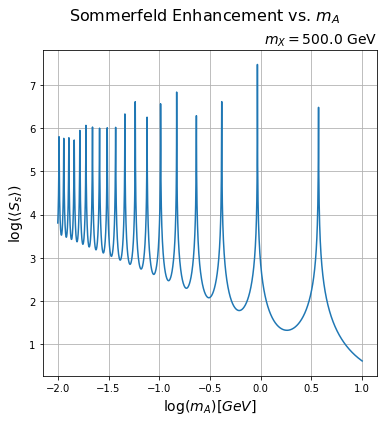

In [8]:
#####################
# Extract Plot Data
#####################
mAList = dataIn['mA[GeV]']
SommerfeldList = dataIn['ThermAvgSommerfeld']
Filem_X = float(dataIn.loc[0,'mX[GeV]'])

##################################
# Determine the diplay Units of m_X 
##################################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'

#####################
# Plot
#####################
fig = plt.figure(figsize = (6,6))
Plot = plt.plot(np.log10(mAList),np.log10(SommerfeldList))
plt.ylabel(r'$\log( \langle S_s \rangle )$', fontsize = 14)
plt.xlabel(r'$\log( m_A ) [GeV]$', fontsize = 14)
plt.suptitle('Sommerfeld Enhancement vs. $m_A$',fontsize = 16)
plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),loc = 'right', fontsize = 14)
plt.grid()

print ('Complete')

# Junk

I'm trying to figure out how to make the contour plot display log values. In log-log space, we should never see a "0" on either axis. Its plotting the values in log space, but its displaying the axis in linear space. 

In [3]:
rawData = pd.read_csv(photonSignalDataPath_Complete('100GeVSignal.csv'))
Filem_X = float(rawData.loc[0,'mX[GeV]'])

#Pull out min / max values
xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
gridDim = int(rawData.loc[0,'Resolution'])



#########################################
# Create the n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(np.log10(xMin), np.log10(xMax) , gridDim, base = 10)
yLogRange = np.logspace(np.log10(yMin), np.log10(yMax), gridDim, base = 10)

#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLogRange), len(yLogRange)))

print ('Complete')

Complete


C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


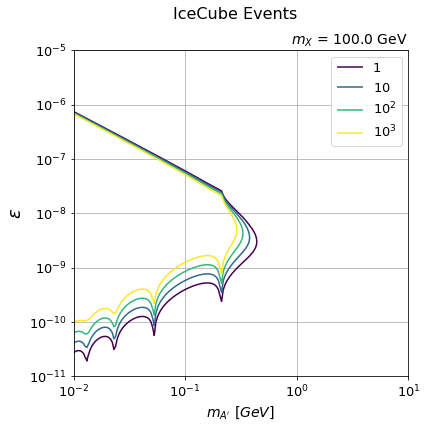

In [11]:
from matplotlib import ticker


##############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Plotting Stuff
###############################
fig0 = plt.figure(figsize = (6,6))

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3],\
                )

xLabelNums = [-2,-1,0,1]
xLabelText = [r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$']

yLabelNums = [-5,-6,-7,-8,-9,-10,-11]
yLabelText = [r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', \
              r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$']


plt.xticks(xLabelNums, xLabelText, fontsize = 13)
plt.yticks(yLabelNums, yLabelText, fontsize = 13)

plt.xlabel(r"$m_{A'}$ $[GeV]$", fontsize = 14)
plt.ylabel(r'$\varepsilon$', fontsize = 18)
plt.suptitle('IceCube Events', fontsize = 16)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 14)


labels = [r'1', r'$10$',r'$10^2$',r'$10^3$']
for i in range(len(labels)):
    CP.collections[i].set_label(labels[i])

plt.legend(loc='upper right', fontsize = 13)

plt.grid()

In [17]:
filename = input('name: ')

fig0.savefig(photonSignalPlotPath(filename), dpi = 700, bbox_inches = 'tight')
print ('Complete')

name: c
Complete
